In [217]:
import os
import datetime
import yaml

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib

from nibabel.streamlines.tractogram import Tractogram, PerArraySequenceDict
from nibabel.streamlines.array_sequence import ArraySequence
from nibabel.streamlines.tck import TckFile

In [195]:
def fiber_geometry(fiber, n_pts="auto", smoothing=1):
    """
    fiber: [[x1,y1,z1],...,[xn,yn,zn]]
    """
    
    tck, u = interpolate.splprep(fiber.T.reshape(3, -1), s=smoothing)

    if n_pts == "auto":
        flen = np.linalg.norm(fiber[1:] - fiber[:-1], axis=1).sum()
        n_pts = int(flen/2) # if units are in mm, pts are on average 2 mm apart

    pts = np.linspace(0, 1, n_pts)

    r = np.dstack(interpolate.splev(pts, tck))[0]
    r1 = np.dstack(interpolate.splev(pts, tck, der=1))[0]
    r2 = np.dstack(interpolate.splev(pts, tck, der=2))[0]
    r3 = np.dstack(interpolate.splev(pts, tck, der=3))[0]

    r1xr2 = np.cross(r1, r2)

    t = r1
    t /= np.linalg.norm(t, axis=1, keepdims=True)

    b = r1xr2
    b /= np.linalg.norm(b, axis=1, keepdims=True)

    n = np.cross(b, t)

    k = np.linalg.norm(r1xr2, axis=1, keepdims=True)
    k /= np.linalg.norm(r1, axis=1, keepdims=True)**3

    tau = np.sum(r1xr2 * r3, axis=1, keepdims=True)
    tau /= np.linalg.norm(r1xr2, axis=1, keepdims=True)**2
    
    return r, t, b, n, k, tau, n_pts

In [222]:
def resample(tck_path, n_pts="auto", smoothing=5, save=True):
        
    fibers = nib.streamlines.load(tck_path).tractogram.streamlines
        
    position = ArraySequence()
    tangent = ArraySequence()
    binormal = ArraySequence()
    mainnormal = ArraySequence()
    curvature = ArraySequence()
    torsion = ArraySequence() 
    rows = 0
    
    for i, f in enumerate(fibers):
        r, t, b, n, k, tau, cnt = fiber_geometry(f, n_pts=n_pts, smoothing=smoothing)
        position.append(r, cache_build=True)
        tangent.append(t, cache_build=True)
        binormal.append(b, cache_build=True)
        mainnormal.append(n, cache_build=True)
        curvature.append(k, cache_build=True)
        torsion.append(tau, cache_build=True)
        rows += cnt
        print("Finished {:3.0f}%".format(100*(i+1)/len(fibers)), end="\r")
        
    position.finalize_append()
    tangent.finalize_append()
    binormal.finalize_append()
    mainnormal.finalize_append()
    curvature.finalize_append()
    torsion.finalize_append()
    
    data_per_point = PerArraySequenceDict(
        n_rows = rows,
        t = tangent,
        b = binormal,
        n = mainnormal,
        k = curvature,
        tau = torsion
    )
    
    tractogram = Tractogram(
        streamlines=position,
        data_per_point=data_per_point,
        affine_to_rasmm=np.eye(4)
    )
    
    if save:
        timestamp = datetime.datetime.now().strftime("-%Y-%m-%d-%H:%M:%S")
        basename = os.path.basename(tck_path)
        name = basename.split(".")[0]
        dir_name = os.path.join("resampled", name + timestamp)
        os.makedirs(dir_name)
    
        TckFile(tractogram=tractogram).save(os.path.join(dir_name, basename))
        
        config = dict(n_pts=n_pts, smoothing=smoothing)
        
        with open(os.path.join(dir_name, "config" + ".yml"), "w") as file:
            yaml.dump(config, file, default_flow_style=False) 
    
    return tractogram

In [223]:
tractogram = resample("CC.tck")

/local/home/vwegmayr/miniconda2/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


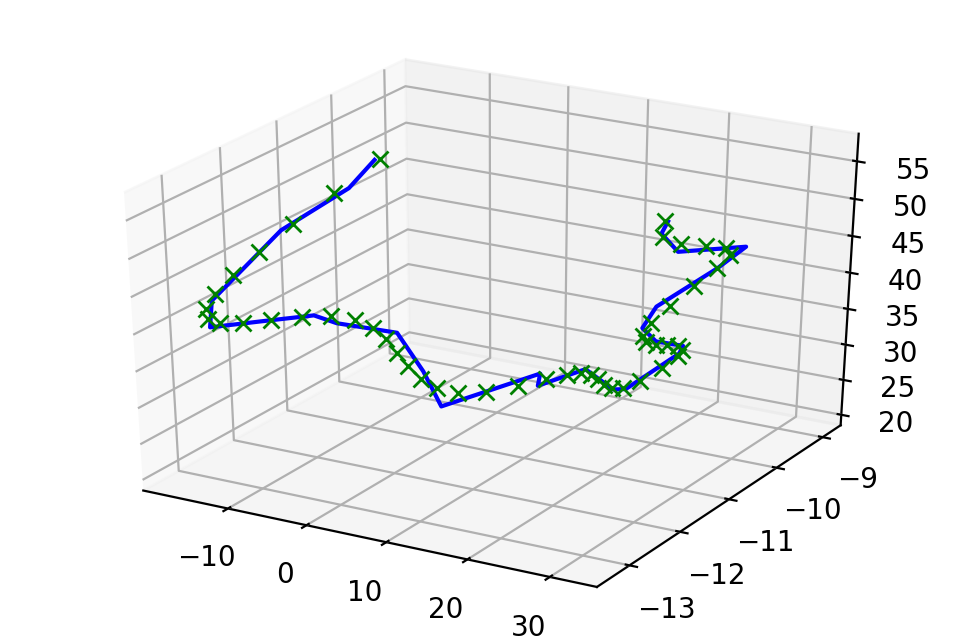

In [202]:
# 3D example

n_pts = 50

r, _, _, _, _, _, _ = fiber_geometry(fibers[0], n_pts=n_pts, smoothing=5)

fig2 = plt.figure(dpi=200)

ax3d = fig2.add_subplot(111, projection='3d')
ax3d.plot(fibers[0][:,0], fibers[0][:,1], fibers[0][:,2], 'b')
ax3d.plot(r[:,0], r[:,1], r[:,2], 'xg')
fig2.show()
plt.show()